<a href="https://colab.research.google.com/github/punch-boxing/punch-ml/blob/main/punch_ml_pytorch_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Settings

In [ ]:
# default values
PUNCH_TYPES = {
    "None": 0,
    "Straight": 1,
    "Hook": 2,
    "Body": 3,
    "Uppercut": 4,
}

# values for model training
INPUT_SIZE = 3
HIDDEN_SIZE = 10
NUM_LAYERS = 2
WINDOW_SIZE = 20


# values for preparing data
MAX_DATA_NUMBER = 15 # file counts
ACCELERATION_DATA_TYPE = "Acceleration" # "Acceleration" for "Raw Acceleration"

# 1. Preparing Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PUNCH_ML(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, num_classes=len(PUNCH_TYPES), stateful=False):
        super(PUNCH_ML, self).__init__() # Corrected class name here
        self.stateful = stateful
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.hidden = None  # used only if stateful

        # a layer that puts the accelerometer value into tanh function, this layer makes the accelerometer value from -1 ~ 1
        self.tanh = nn.Tanh()
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, num_classes)

    def reset_state(self, batch_size=1, device='cuda'):
        self.hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

    def forward(self, x):
        x = self.tanh(x)

        if self.stateful:
            out, self.hidden = self.gru(x, self.hidden.detach())
        else:
            out, _ = self.gru(x)

        out = self.fc(out[-1])  # use last timestep's output
        return out

# 2. Preparing Data

In [ ]:
import pandas as pd

raw_datas = []

# Columns
# Index,Time,Raw Acceleration X,Raw Acceleration Y,Raw Acceleration Z,Acceleration X,Acceleration Y,Acceleration Z,Angular Velocity X,Angular Velocity Y,Angular Velocity Z,Orientation X,Orientation Y,Orientation Z,Punch Type

for i in range(1, MAX_DATA_NUMBER + 1):
  try:
    data = pd.read_csv(f"{i}.csv")
    data["Punch Index"] = data["Punch Type"].map(PUNCH_TYPES).fillna(0).astype(int)
    raw_datas.append(data)
  except:
    print(f"No data for {i}.csv")

No data for 11.csv
No data for 12.csv
No data for 13.csv
No data for 14.csv
No data for 15.csv


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

datas = []
targets = []

for data in raw_datas:
  x = data[ACCELERATION_DATA_TYPE + " X"].values
  y = data[ACCELERATION_DATA_TYPE + " Y"].values
  z = data[ACCELERATION_DATA_TYPE + " Z"].values
  punch = data['Punch Index'].values

  for i in range(len(data) - WINDOW_SIZE):
    datas.append(np.array([
        x[i:i+WINDOW_SIZE],
        y[i:i+WINDOW_SIZE],
        z[i:i+WINDOW_SIZE],
    ]).T) # Transpose to get shape (WINDOW_SIZE, num_features)
    targets.append(punch[i + WINDOW_SIZE])


X = np.array(datas)
y = np.array(targets)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
    batch_size=64,
    shuffle=False
)

for data, target in train_loader:
  print(data.shape, target.shape)
  break

print(X_train.shape)
print(X_test.shape)

torch.Size([64, 20, 3]) torch.Size([64])
(6228, 20, 3)
(1558, 20, 3)


# 3. Compiling Model

In [ ]:
from torchsummary import summary

print(f"Using Device : {device}")

model = PUNCH_ML().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

summary(model, (WINDOW_SIZE, INPUT_SIZE))


Using Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              Tanh-1                [-1, 20, 3]               0
               GRU-2  [[-1, 20, 10], [-1, 20, 10]]               0
            Linear-3                    [-1, 5]              55
Total params: 55
Trainable params: 55
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.00
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


# 4. Training Model

In [ ]:
# import torch

# best_loss = float('inf')
# epochs = 100
# patience = 5
# counter = 0

# train_loss_history = []
# val_loss_history = []
# train_accuracy_history = []
# val_accuracy_history = []

# for epoch in range(epochs):
#   model.train()
#   train_loss = 0.0

#   for data, target in train_loader:
#       data = data.permute(1, 0, 2).to(device, dtype=torch.float32)
#       target = target.to(device)
#       output = model(data)
#       loss = criterion(output, target)

#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       _, predicted = torch.max(output.data, 1)
#       correct = (predicted == target).sum().item()
#       accuracy = correct / target.size(0)

#       train_accuracy_history.append(accuracy)
#       train_loss += loss.item()

#   train_loss /= len(train_loader)
#   train_loss_history.append(train_loss)

#   model.eval()
#   val_loss = 0.0
#   with torch.no_grad():
#       for data, target in test_loader:
#           data = data.permute(1, 0, 2).to(device, dtype=torch.float32)
#           target = target.to(device)

#           output = model(data)
#           loss = criterion(output, target)

#           _, predicted = torch.max(output.data, 1)
#           correct = (predicted == target).sum().item()
#           accuracy = correct / target.size(0)

#           val_accuracy_history.append(accuracy)
#           val_loss += loss.item()

#   val_loss /= len(test_loader)
#   val_loss_history.append(val_loss)

#   print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f} Val")

#   if val_loss < best_loss:
#       best_loss = val_loss
#       counter = 0
#       # torch.save(model.state_dict(), 'best_model.pth')  # Optional
#   else:
#       counter += 1
#       if counter >= patience:
#           print("Early stopping")
#           break

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.permute(1, 0, 2).to(device, dtype=torch.float32)
            target = target.to(device)

            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_correct += (predicted == target).sum().item()
            total_samples += target.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

best_loss = float('inf')
epochs = 100
patience = 5
counter = 0

train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    total_correct = 0
    total_samples = 0

    for data, target in train_loader:
        data = data.permute(1, 0, 2).to(device, dtype=torch.float32)
        target = target.to(device)

        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == target).sum().item()
        total_samples += target.size(0)

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct / total_samples
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/100 | Train Loss: 0.8937 | Train Accuracy: 0.8353 | Val Loss: 0.2726 | Val Accuracy: 0.9685
Epoch 2/100 | Train Loss: 0.2432 | Train Accuracy: 0.9637 | Val Loss: 0.1935 | Val Accuracy: 0.9685
Epoch 3/100 | Train Loss: 0.2116 | Train Accuracy: 0.9637 | Val Loss: 0.1820 | Val Accuracy: 0.9685
Epoch 4/100 | Train Loss: 0.2063 | Train Accuracy: 0.9637 | Val Loss: 0.1774 | Val Accuracy: 0.9685
Epoch 5/100 | Train Loss: 0.2030 | Train Accuracy: 0.9637 | Val Loss: 0.1749 | Val Accuracy: 0.9685
Epoch 6/100 | Train Loss: 0.1995 | Train Accuracy: 0.9637 | Val Loss: 0.1734 | Val Accuracy: 0.9685
Epoch 7/100 | Train Loss: 0.2010 | Train Accuracy: 0.9637 | Val Loss: 0.1722 | Val Accuracy: 0.9685
Epoch 8/100 | Train Loss: 0.1985 | Train Accuracy: 0.9637 | Val Loss: 0.1713 | Val Accuracy: 0.9685
Epoch 9/100 | Train Loss: 0.1958 | Train Accuracy: 0.9637 | Val Loss: 0.1702 | Val Accuracy: 0.9685
Epoch 10/100 | Train Loss: 0.1952 | Train Accuracy: 0.9637 | Val Loss: 0.1685 | Val Accuracy: 0.9685

# 5. Evaluating Model

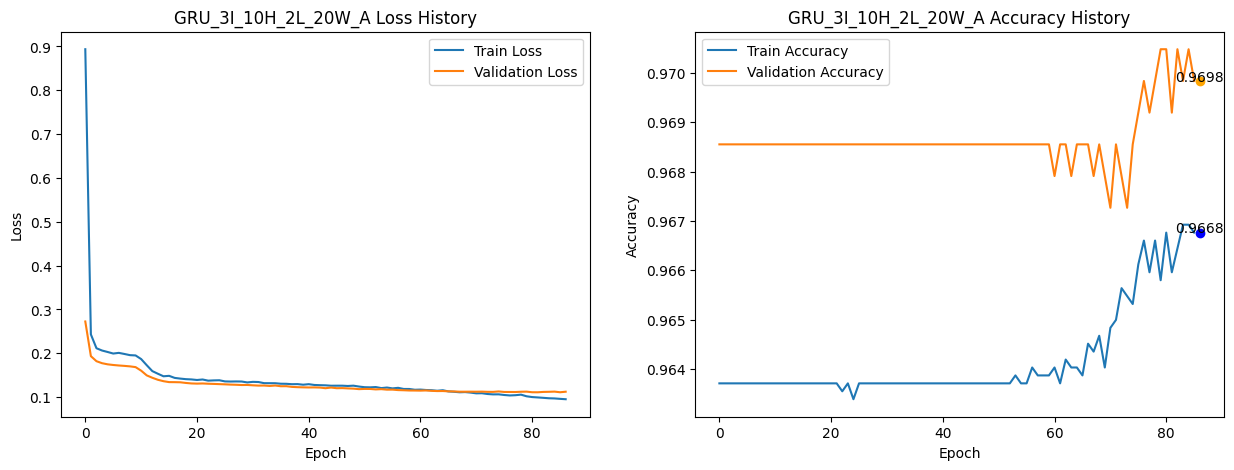

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.title(f"GRU_{INPUT_SIZE}I_{HIDDEN_SIZE}H_{NUM_LAYERS}L_{WINDOW_SIZE}W_{ACCELERATION_DATA_TYPE[0]} Loss History")
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.title(f"GRU_{INPUT_SIZE}I_{HIDDEN_SIZE}H_{NUM_LAYERS}L_{WINDOW_SIZE}W_{ACCELERATION_DATA_TYPE[0]} Accuracy History")
plt.plot(train_accuracy_history[1:], label='Train Accuracy')
plt.plot(val_accuracy_history[1:], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 마지막 Accuracy 점 찍기 및 텍스트 표시
last_epoch = len(train_accuracy_history) - 1

# Train accuracy
plt.scatter(last_epoch, train_accuracy_history[-1], color='blue')
plt.text(last_epoch, train_accuracy_history[-1],
         f"{train_accuracy_history[-1]:.4f}",
         color='black', ha='center')


# Validation accuracy
plt.scatter(last_epoch, val_accuracy_history[-1], color='orange')
plt.text(last_epoch, val_accuracy_history[-1],
         f"{val_accuracy_history[-1]:.4f}",
         color='black', ha='center')

# 저장 및 출력
plt.savefig(f"GRU_{INPUT_SIZE}I_{HIDDEN_SIZE}H_{NUM_LAYERS}L_{WINDOW_SIZE}W_{ACCELERATION_DATA_TYPE[0]}_GRAPH")
plt.show()


In [ ]:
# model.eval()

# test_loss, correct = .0, 0

# with torch.no_grad():
#   for data, target in test_loader:
#     data, target = data.permute(1, 0, 2).to(device, dtype = torch.float32), target.to(device)
#     output = model(data)
#     test_loss += criterion(output, target).item()
#     correct += (output.argmax(1) == target).sum().item()

# print('Test Loss: {:.6f}'.format(test_loss / len(test_loader)))
# print('Accuracy: {:.3f}%'.format(100. * correct / len(test_loader.dataset)))


In [ ]:
model(data.to(device, dtype = torch.float32)[0][0].unsqueeze(0).unsqueeze(1))

tensor([[ 0.9508,  0.3272, -0.5618, -0.2580, -2.0523]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

# 6. Downloading Model

In [ ]:
# result = torch.jit.trace(model, data.permute(1, 0, 2).to(device, dtype = torch.float32))

# result.save(f"GRU_{INPUT_SIZE}I_{HIDDEN_SIZE}H_{NUM_LAYERS}L_{WINDOW_SIZE}W.pt")

In [ ]:
!pip install onnx

In [ ]:
import torch.onnx

torch.onnx.export(
    model,
    data.permute(1, 0, 2).to(device, dtype=torch.float32),
    f"GRU_{INPUT_SIZE}I_{HIDDEN_SIZE}H_{NUM_LAYERS}L_{WINDOW_SIZE}W_{ACCELERATION_DATA_TYPE[0]}.onnx",
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'seq_len', 1: 'batch_size'},
    },
    opset_version=12
)

/usr/local/lib/python3.11/dist-packages/torch/onnx/symbolic_opset9.py:4277: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
